# PIT - Práctica 1: Análisis de Series Temporales - Modelos Clásicos

**Alicia Lozano Díez**
 
14 de febrero de 2022


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento y análisis de señales temporales: descomposición de una serie temporal para el estudio de sus propiedades, ajuste de modelos lineales (ARIMA) y predicción.

### Materiales - Moodle

- Guión (.ipynb) de la práctica
- Datos (.csv): bases de datos _AirPassengers.csv_ y _COVIDVaccinationCZ.csv_.


# 1. Introducción al procesamiento de señales temporales: Air Passengers

## 1.1. Manejo de los datos en Python

Primero vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un periodo de tiempo.


A continuación, vamos a leer el fichero *AirPassengers.csv* en Python, con la ayuda de la librería *pandas*.

Lo cargaremos haciendo uso también del módulo de Python *datetime* para operar con este tipo de datos de forma cómoda.

La función definida *parser* nos permitirá cambiar el formato de fecha/tiempo al formato que esperamos encontrar en nuestra base de datos.

In [1]:
from pandas import read_csv
from datetime import datetime
 
def parser(x):
    return datetime.strptime(x, '%Y-%m')
 
data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, 
                squeeze=True, date_parser=parser)
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


/tmp/ipykernel_3508/2395733750.py:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0,


Podemos visualizar cómo está indexada la estructura de datos, así como el número de datos que tiene nuestra serie temporal.

In [2]:
data.index


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Si queremos acceder a un dato en concreto, por ejemplo, el número de pasajeros del mes de marzo de 1949, podemos hacerlo de la siguiente forma:

In [3]:
data['1949-03-01']


132

O de esta otra:

In [4]:
data[datetime(1949,3,1)]

132

## 1.2. Representación de los datos


El primer paso para analizar una serie temporal es obtener una representación de los datos, para poder hacernos una idea de las características de la serie de forma visual. 

Para ello, podemos utilizar la librería *matplotlib* como sigue:

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

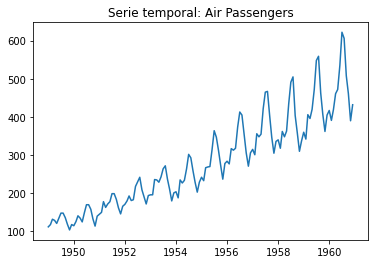

In [5]:
from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.3. Estudio de la estacionariedad de la serie


Algunos de los modelos de análisis de series temporales asumen estacionariedad en las series. Por ello, vamos a ver dos métodos para comprobar si una serie es estacionaria.

Uno de ellos es un análisis más visual: calculamos la media y desviación estándar "móviles" (con una ventana deslizante). 

In [12]:
import pandas as pd

def test_stationarity_1(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation. Window size : {}'.format(window_size))
    plt.show(block=False)

El segundo método consiste en el test estadístico Dickey-Fuller:

In [13]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [14]:
def test_stationarity(timeseries,window_size):
  test_stationarity_1(timeseries,window_size)
  test_stationarity_2(timeseries)

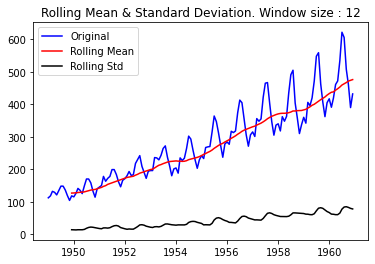

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
test_stationarity(data,12)

**PREGUNTAS**

1.   ¿Qué conclusiones puede extraer del análisis de estacionariedad de la serie original?
2.   ¿Qué diferencias observas al variar el tamaño de la ventana para hacer las medias móviles? Prueba con un par de tamaños, incluye las gráficas obtenidas y explica las diferencias visuales que aprecias.

**Respuestas**

1. Vamos a distinguir entre los dos tipos de *análisis* para dar respuestas a esta pregunta según si el análisis es visual o usando el resultado del test **Dickey-Fuller**.

**a) Análisis visual**

En este análisis podemos ver claramente que la serie **no es estacionaria**. Para que una distribución sea [estacionaria](https://en.wikipedia.org/wiki/Stationary_process), tenemos que tener que la distribución conjunta no condicionada es invariante a traslaciones con el tiempo, es decir, la media y la desviación típica se mantienen constantes en el tiempo. Reafirmamos que en este caso, vemos como la media tiene una tendencia creciente y lo mismo ocurre con la desviación típica.

**b) Análisis con el test Dickey-Fuller**

El test de Dickey-Fuller comprueba la hipótesis nula $H_0$ de que una raíz unitaria está presente en el modelo que hemos supuesto autorregresivo. Sabemos que si un modelo tiene una [raíz unitaria](https://en.wikipedia.org/wiki/Unit_root), el proceso será no estacionario, a pesar de que no siempre tenga una tendencia. Por tanto, la hipótesis alternativa $H_1$ nos indicará si el modelo **s
í** es estacionario. 

Vemos que, en este caso, el valor del obtenido del estadístico $t$ ($\approx 0.81$) queda aproximadamente $0.2$ por debajo del $p-value$. Además, para cualquiera de los niveles de significancia $\alpha$, este $p-value$ será mayor que el valor crítico, por lo que no podemos rechazar la hipótesis nula, lo que nis indicaría que es muy probable que el modelo tenga una raíz unitaria, haciendo a este modelo **no estacionario**.

Esta última afirmación **concuerda** además con lo obtenido en el análisis visual de la serie.

2. Para responder a este apartado, vamos a realizar una serie de gráficas que nos ayuden a ver este resultado.

Lo primero que es conveniente resaltar es que la serie presenta a simple vista cierta **estacionalidad**, es decir, tenemos un comportamiento que se repite aproximadamente cada año. Además, sabiendo que los datos están tomados mes a mes, el tamaño de ventana coincidirá con el número de meses que estamos considerando para calcular la media y desviación típica. Realizamos las gráficas comentadas


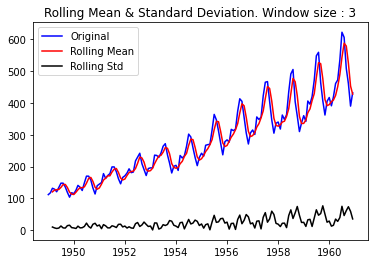

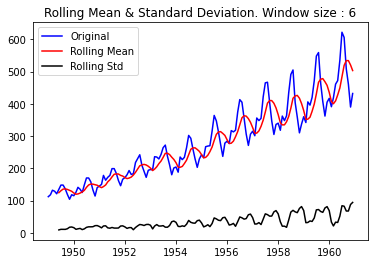

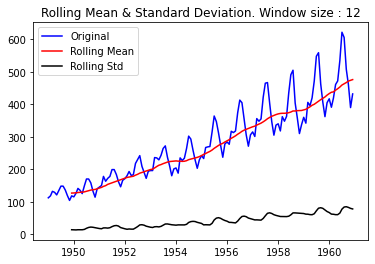

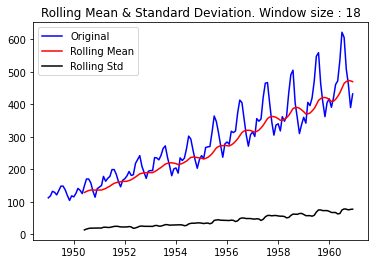

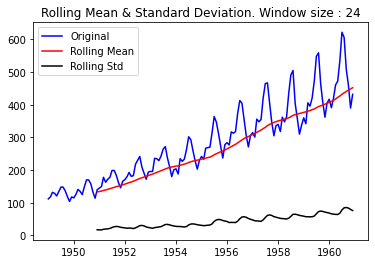

In [16]:
n_months = [3,6,12,18,24]
for months in n_months:
    test_stationarity_1(data,months)
    

Se puede observar cómo cuando tomamos un número de meses (tamaño de ventana) menor, la media se aproxima mucho a la gráfica original y aumenta la varianza, mientras que al aumentar el tamaño hasta una ventana de dos años, se suavizan ambas componentes. Esto tiene sentido, pues al tomar un número de meses más grande estamos reduciendo la componente de **estacionalidad** que tiene la serie que hemos dicho que parece ser a simple vista de un período de $1$ año. Esta se reduce pues estamos tomando valores cuando la *estación* ya se ha repetido más de una vez.

## 1.4. Transformar una serie temporal en estacionaria

Como hemos visto en la teoría, para analizar la serie y poder ajustarle un modelo tipo AR, MA o ARMA, esperamos que la serie a modelar sea estacionaria. 

Para conseguir una serie lo más estacionaria posible, podemos aplicar distintas transformaciones de la serie original. Vamos a ver algunos ejemplos:

a) *Transformaciones simples para reducir el efecto de la tendencia*:

En el caso de los datos del ejemplo, la tendencia es positiva, por lo que podemos aplicar alguna transformación que penalice los valores más altos y menos los más bajos. Es el caso del logaritmo, la raíz cuadrada, etc. 

**PREGUNTA**


1.   Representa a continuación la serie aplicándole una transformación logarítmica. ¿Qué observas?



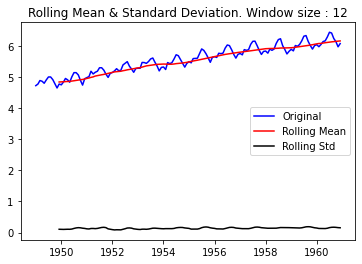

In [18]:
import numpy as np
log_data = data.apply(np.log)
test_stationarity_1(log_data,window_size = 12)

**Respuesta**

Se **observa** que se ha suavizado mucho el crecimiento que tenía la serie, y ahora la **tendencia** de la media es mucho menor que en el caso anterior. Hemos conseguido por tanto lo que se pretendía que era penalizar los valores más altos, haciéndolos más cercanos a los valores más pequeños para frenar esa tendencia creciente y aumentando así la estacionaridad: vemos que la **desviación típica** ya es casi constante y la media tiene un crecimiento muy lento.

En casos más complejos en los que la tendencia no se ve clara (sobre todo en presencia de ruido), se pueden aplicar otros métodos. Uno de ellos es el suavizado como las medias móviles (*moving average*). 

Por ejemplo, podemos aplicar un suavizado con una media con ventana deslizante que tenga en cuenta un año (12 meses). 
Ten en cuenta, que esto implicará que para calcular la media de las primeras muestras, no tengo suficientes datos para la ventana. Esto lo podemos ver en la salida de la media móvil (tendremos que eliminar los *NaN* que aparecen).


**PREGUNTAS**


1.   Aplica dicha media móvil y represéntala junto a los datos. Puede utilizar los datos en escala logarítmica. ¿Esta media móvil representa claramente la tendencia de la serie?

2.   Elimina ahora de la serie original (transformada con el logaritmo si es como la has calculado previamente) la influencia de esta media móvil y representa el resultado. ¿Qué observas ahora?

3.   Realiza el test de estacionariedad de la serie resultante y compáralo con el de la serie original. ¿Qué conclusiones puedes obtener tanto del test visual como del test estadístico?

**RESPUESTAS**

Respondemos una a una las preguntas, incluyendo código entre las respuestas para una mayor comodidad en la lectura.

1. Vamos a aplicar el suavizado mediante media móvil en ambos casos, viendo cuál es el resultado para cada uno de los casos, tanto sin hacer el logaritmo como haciéndolo.



Original data


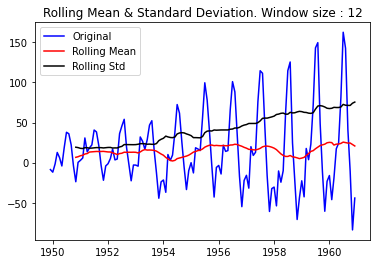



 Logarithm data


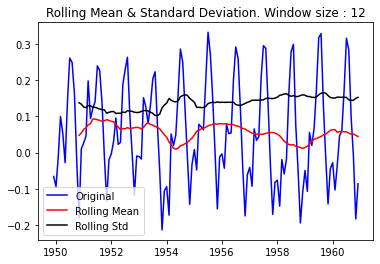

In [27]:
data_sub_mean = (data-data.rolling(window = 12).mean().dropna()).dropna()
log_data_sub_mean = (log_data-log_data.rolling(window = 12).mean().dropna()).dropna()

print("Original data")
test_stationarity_1(data_sub_mean, window_size = 12)
print("\n\n Logarithm data")
test_stationarity_1(log_data_sub_mean, window_size = 12)

Se observa en ambos casos cómo conseguimos que la media se mantenga ciertamente más constante, aunque **no representa claramente** la tendencia de la serie, pues tenemos ahora una desviación típica muy alta (en los ca

b) *Diferenciar (derivar)*:

Las técnicas anteriores son sencillas y pueden eliminar parte de la influencia de la tendencia de la serie, pero no suelen ser suficientes cuando se tiene por ejemplo estacionalidad. 

Diferenciar (o derivar) es uno de los métodos más comunes para eliminar la influencia de la tendencia y la estacionalidad en la serie original, mejorando las propiedades de estacionariedad de la serie. 

Podemos tomar la derivada de orden uno de la siguiente manera (partimos de la serie en el dominio logarítmico): 

In [ ]:
data_log_diff = data_log - data_log.shift()
plt.plot(data_log_diff)

**PREGUNTAS**


1.   ¿Qué observas en la serie resultante?
2.   ¿Es esta serie estacionaria de acuerdo a los criterios anteriores? Incluye los resultados gráficos y del test estadístico e interprétalos.
3. Repite el proceso para una segunda derivada. ¿Qué observas ahora?



c) *Descomposición de la serie*:

La mayoría de series pueden descomponerse en tendencia, estacionalidad y residuo, como hemos visto en clase. 

Utilizando la función *seasonal_decompose* del módulo de Python *statsmodels* podemos obtener estas tres componentes y por tanto, modelarlas por separado: 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**PREGUNTAS**

1.   ¿Es la señal residual estacionaria? Realiza el test y comenta los resultados.



## 1.5. Modelado ARIMA y predicción

Uno de los modelos clásicos para series temporales vistos en clase es el modelo ARIMA, que permite derivar *d* veces, y aplicar *p* coeficientes autorregresivos (AR) y *q* términos de error (shocks, provenientes de la parte MA) en la combinación lineal.  

Para determinar el valor de los parámetros *p* y *q*, podemos hacer uso de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). 

Si calculamos dichas funciones para la serie derivada previamente, obtenemos lo siguiente:

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

Podemos añadir además un intervalo de confianza a ambos lados del valor cero, de tal manera que el primer valor de retardo que cruce ese intervalo por arriba en la función de PACF será el valor de *p*, y de ACF, será *q*.

Para los niveles de confianza estándar, el valor del límite del intervalo de confianza al 95% es 1.96. Suponiendo desviación estándar unidad, el límite estaría en (-1.96/sqrt(N), 1.96/sqrt(N)), donde N es el número de puntos. 

Si incluimos estos límites en la figura anterior, podemos obtener una buena aproximación de los valores de *p* y *q* para el modelo ARIMA:

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**PREGUNTAS**


1.   ¿Qué valores de *p* y *q* utilizarías para un primer modelo ARIMA de acuerdo a las representaciones anteriores?



Una vez elegidos los valores de *p* y *q*, podemos utilizar también la derivación interna de la clase ARIMA (*d*) o aplicarlo sobre la serie previamente derivada con valor de *d=0*. 

A continuación, importamos el modelo ARIMA de la siguiente manera. 

Este modelo tiene como argumentos los datos, y el orden: 

model = ARIMA(datos, order = (p,d,q))

In [ ]:
from statsmodels.tsa.arima_model import ARIMA


**PREGUNTAS**


1.   A continuación, completa los valores de p, d y q y utiliza el siguiente código para ajustar un modelo tipo AR. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

2.    Repite el código con los valores de los parámetros correspondientes para ajustar un modelo MA. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

3.    Repite nuevamente el código para combinar los modelos anteriores (ARMA). Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

4.   De acuerdo a los valores de RSS, ¿cuál dirías que es el modelo que mejor se ajusta a los datos?

In [ ]:
p = 
d = 
q = 

# AR
model = ARIMA(data_log, order=(p, d, q))  
results_AR = model.fit(disp=-1)  
plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_diff)**2)) 
# RSS: Residual sum of squares

Por último, para predecir valores en el espacio original, tenemos que deshacer las transformaciones realizadas hasta el momento. 

Primero, tomamos los valores ajustados por el modelo (predicciones) y los guardamos como serie temporal. 

Estos valores empiezan en el segundo mes, puesto que hemos tomado diferencias (derivada) de orden 1.

In [ ]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Segundo, deshacemos la operación de diferencias (en escala logarítmica), con una suma acumulativa y añadiéndoles el valor "base" (primer elemento de la serie). 

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [ ]:
predictions_ARIMA_log = pd.Series(data_log[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Finalmente, aplicamos la función exponencial (inversa del logaritmo).

Podemos calcular el error cuadrático medio en el espacio original. 

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

# 2. Aplicación a otros datos: Vacunación COVID República Checa


Vamos a cargar ahora los datos sobre la vacunación COVID de República Checa (*COVIDVaccinationCZ.csv*):

Esta base de datos, contiene los datos de vacunación de República Checa desde el 27 de diciembre de 2020 hasta el 7 de febrero de 2022. 

In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
data = read_csv('COVIDVaccinationCZ.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(data.head())

In [ ]:
from matplotlib import pyplot as plt
plt.plot(data)

**PREGUNTAS**

Utilizando las herramientas del apartado 1, realiza el análisis de esta serie (puedes utilizar un intervalo de ella o la serie completa). 

En concreto:
1.   Analiza la estacionariedad de esta serie. 
2.   ¿Qué transformaciones puedes realizar para hacerla más estacionaria? Prueba algunas y justifica si consigues una serie más estacionaria. 
3.   Ajusta un modelo ARIMA, y calcula el error de predicción. 



In [ ]:
#### CÓDIGO AQUÍ ####